## GOAL: Build a simple implementation of gradient-boosted trees from scratch to predict housing prices in Boston.

### 1. Get the Data

In [1]:
from sklearn.datasets import load_boston
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

boston = load_boston()
X = boston.data
ytrue = boston.target

### 2. Start with an initial prediction ("bad" first guess)

In [2]:
y0 = np.array([ytrue.mean()] * len(ytrue))

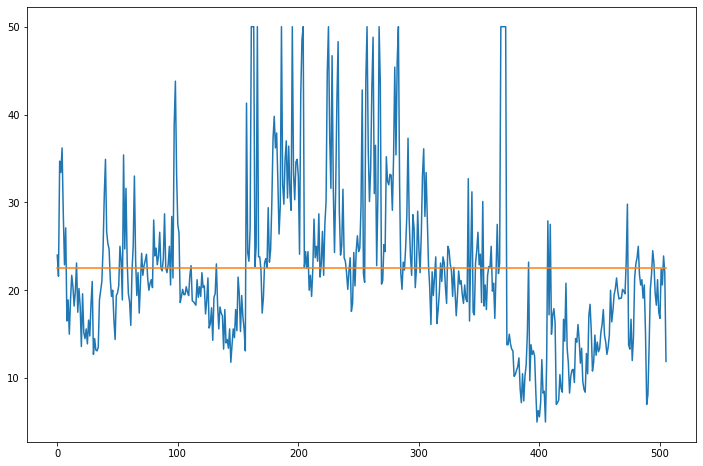

In [3]:
plt.figure(figsize=(12,8))
plt.plot(ytrue)
plt.plot(y0)

### 3. Write an error function (i.e. something that tells us how good or bad our prediction is)

In [4]:
def compute_error(ytrue, y_hat):
    """Error for each individual point"""
    
    error = (ytrue - y_hat)**2 / 2
    
    return error

In [5]:
compute_error(ytrue, y0).mean() # basicially the MSE

42.20977807808278

### 4. Visualize the error gradient
Let's look at one specific point


In [6]:
ytrue[0], y0[0]

(24.0, 22.532806324110677)

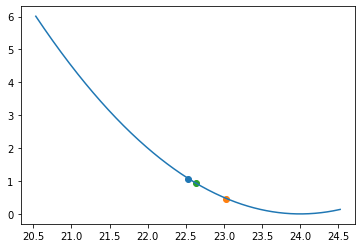

In [7]:
losses = []

for i in np.arange(-2, 2, 0.01):
    error = compute_error(ytrue[0], y0[0] + i)
    losses.append(error)

plt.scatter(y0[0], compute_error(ytrue[0], y0[0]))
plt.scatter(y0[0] + 0.5, compute_error(ytrue[0], y0[0] + 0.5))
plt.scatter(y0[0] + 0.1, compute_error(ytrue[0], y0[0] + 0.1))

plt.plot(y0[0] + np.arange(-2, 2, 0.01), losses)

In [8]:
delta_pred = 0.1
delta_error = compute_error(ytrue[0], y0[0] + 0.1) - compute_error(ytrue[0], y0[0])

delta_error / delta_pred

-1.4171936758893422

### 5. Calculate the Derivative / Gradient 
(for convenience)

$$error = \frac{( y-\hat{y})^2}{2}$$

$$\frac{\delta (error)}{\delta \hat{y}}  = -1*( y-\hat{y})$$

In [9]:
def error_gradient(ytrue, ypred):
    return -(ytrue - ypred)

In [10]:
error_gradient(ytrue, y0)[0]
# we were pretty close!

-1.4671936758893231

### 6. Calculate the pseudo-residuals

In [11]:
pseudo_residuals = -error_gradient(ytrue, y0)
# we want to move in the direction OPPOSITE of increasing error

### 7. Train a weak model on the data to predict these pseudo-residuals


In [12]:
from sklearn.tree import DecisionTreeRegressor

In [13]:
regressor = DecisionTreeRegressor(max_depth=1)

In [14]:
regressor.fit(X, pseudo_residuals) # we want to fit on the pseduo residuals, not on the target value

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=1,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

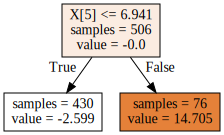

In [15]:
from sklearn.tree import export_graphviz
import graphviz

tree = export_graphviz(regressor, out_file=None, impurity=False, filled=True)
open('boston.dot', 'w').write(tree)
graph = graphviz.Source(tree)
graph

### 8. Make new predictions!

In [16]:
y1 = y0 + regressor.predict(X)

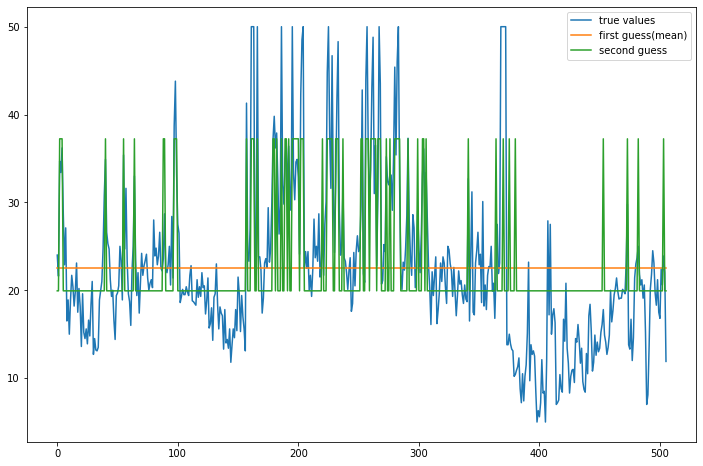

In [17]:
plt.figure(figsize=(12,8))
plt.plot(ytrue)
plt.plot(y0)
plt.plot(y1)
plt.legend(['true values', 'first guess(mean)', 'second guess'])

In [18]:
### Let's do it once more!
pseudo_residuals = -error_gradient(ytrue, y0)
regressor.fit(X, pseudo_residuals)
y2 = y1 + regressor.predict(X)


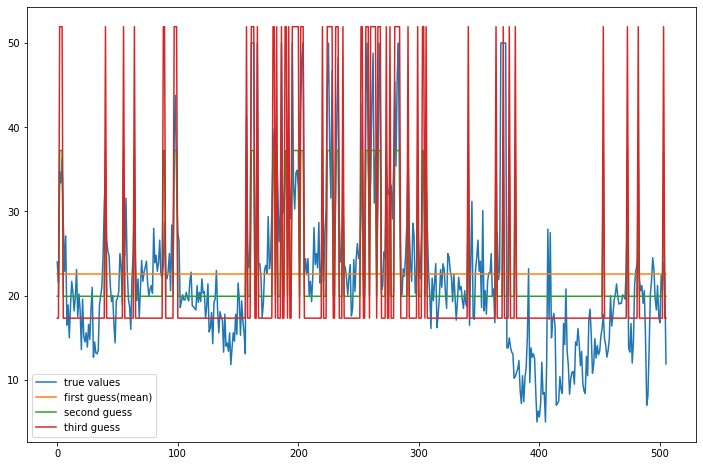

In [19]:
plt.figure(figsize=(12,8))
plt.plot(ytrue)
plt.plot(y0)
plt.plot(y1)
plt.plot(y2)

plt.legend(['true values', 'first guess(mean)', 'second guess', 'third guess'])

---

### 9. Put it all into a loop!

In [20]:
def gradient_boost_train(X, ytrue, n):
    
    """Simple Version of the Gradient Boosting Algorithm"""
    
    y_hat = [ytrue.mean()] * len(ytrue) # first prediction!
    
    y0 = y_hat # save the initial prediction
    
    regressors = []
    
    for i in range(n):
        
        # 1. Calculate Pseudo-Residuals
        pseudo_residuals = -error_gradient(ytrue, y_hat)
        
        # 2. Train a tree!
        
        regressor = DecisionTreeRegressor(max_depth=1)
        regressor.fit(X, pseudo_residuals)
        
        # 3. Update our prediction!
        y_hat = y_hat + regressor.predict(X)
        
       # print(compute_error(ytrue, y_hat).mean())
        
        regressors.append(regressor)
        
    return regressors, y0

In [21]:
regressors, y0 = gradient_boost_train(X, ytrue, 50)
regressors # collection of 50 trees 

[DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=1,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=1,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=1,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impur

### Step 10. Make some predictions!

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, ytrue, random_state=42)

In [23]:
def gb_predict(X_test, y0, regressors):
    
    y_hat = np.array(y0[0] * len(X))
    # we need to make our first prediction the mean of the training data but readjust the length
    
    for r in regressors:
        
        y_hat = y_hat + r.predict(X_test)
        
    return y_hat

In [24]:
#### STEP 1: TRAIN

regressors, y0 = gradient_boost_train(X_train, y_train, 50)

### STEP 2: PREDICT
final_prediction = gb_predict(X_test, y0, regressors)

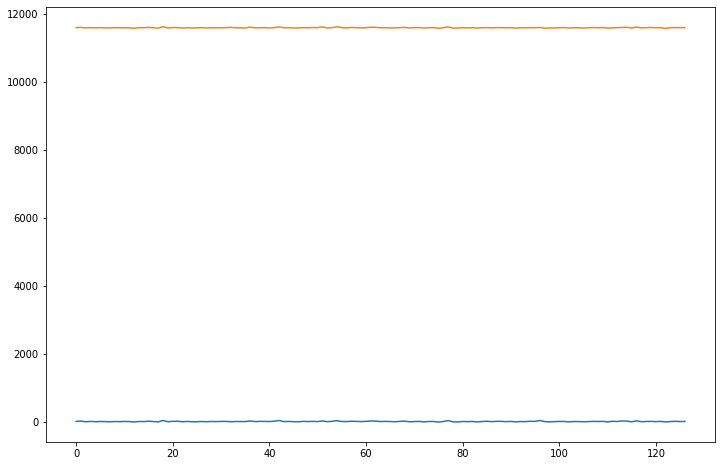

In [25]:
plt.figure(figsize=(12,8))
plt.plot(y_test)
plt.plot(final_prediction)

---

### Python Implementations

1. Catboost (Yandex) - 2017
2. LightGBM (Microsoft) - 2016
3. XGBoost (open-source) - 2014

---